<h1>Sampling Experimentation with Noise Grids</h1>

First, the packages needed for the experiment are imported and the font size for figures is set.

In [98]:
#import packages and define the model to sample from
from math import sqrt
from collections import deque
import random
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
font = {
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)
#np.#random.seed(8)
# LPS: I've un-hardcoded the maximum distance at which we sample data. 
# LPS: I've now made the bounds a constant that you can change easily
LowerBound = 100
MaxDistance = 4000
e = 0.15
# LPS: I've un-hardcoded the true value as we might want to play with this later. 
ValueTRUE = 400

<h2>Generating Noise Grid</h2>

Generates a noisy grid with the specified number of decimal places.

In [99]:
#how many decimal places are required for noise grid?
places = 2
#Create noise values to 0.1km precision for given bounds. the bounds need to be integers for this function
def create_noise_grid(lb,ub,e):
    numints = (ub-lb)+1 #the number of cells needed for a given range
    noiseGrid = []
    for i in range(0,numints): #the UB is not included in the loop but comes after
        tmp = []
        for j in range(0,(10**places)): #get noise for each 0.1km value and add it to the list. 
            tmp.append(np.random.normal(0.0, e, 1)[0])
        noiseGrid.append(tmp)
    return noiseGrid
noiseGrid = (create_noise_grid(LowerBound,MaxDistance,e))
#print(noiseGrid)

def getNoise(dist):
    #print(dist)

    dist = round(dist,places) #round to given decimal place position
    
    intval, decval = divmod(dist, 1) #separate the numbers before and after the decimal point
    intval = int(intval)
    decval = int((round(decval,places))*(10**places)) #formatting
    #print("after:",intval,decval)
    return noiseGrid[intval-LowerBound][decval]

print(getNoise(LowerBound))
print(getNoise(100.006))
print(getNoise(MaxDistance))
print(getNoise(MaxDistance+0.406))
print(getNoise(MaxDistance+0.4059))

-0.09773325217108884
0.2859028827094995
0.015111825815064551
-0.028764752071099957
-0.028764752071099957


In [100]:
def f(x):
    return 2**(- x /400)
vf = np.vectorize(f)
#
dist_array = np.arange(0,4001)                      
#error_array = np.random.normal(0, 0.15, size=4000) 
rho_value = vf(dist_array)      
my_dict = {key: 0 for key in range(0, 4001)} #keep track of how many times a value was accessed
#noisy_rho = rho_value + error_array

def getNoise(d):
    d = round(d) #round to the nearest integer
    count = my_dict[d]
    #print("count",count)
    my_dict[d] += 1 #noise for d value accessed once; increment counter to get different noise
    if(my_dict[d] == 100):
        my_dict[d] = 0 #cycle back to avoid going out of bounds
    return error_arrays[count][d]


error_arrays = []
for i in range(0,100):
    error_array = np.random.normal(0, 0.15, size=4001) 
    error_arrays.append(error_array)
    noisy_rho = rho_value + error_array
    #plt.scatter(x=dist_array, y=noisy_rho, color='g')

    #plt.scatter(x=dist_array, y=rho_value, color='r')
    #plt.show()

print(getNoise(3000.9))
print(getNoise(3000))
print(getNoise(3000))
print(getNoise(3000))
print(getNoise(3000))
print(getNoise(3000))
my_dict = {key: 0 for key in range(0, 4001)}
print(getNoise(3000.9))



-0.15207187325579977
-0.18219061583468327
-0.16892778779577844
-0.05062024421837066
0.008985048231873538
-0.09511058699350662
-0.15207187325579977


<h2>Generating Noisy Artificial Data</h2>

In [101]:
#np.#random.seed(8)

#function to calculate correlation (rho) for distance to cell, d, and correlation distance, D
def cordist(d,D): 
    rho = 2**(-d/D)
    return(rho)


#generate correlation value using the function above, with corr. distance fixed  (D=400km). Distance to grid cell, d, is the input parameter. 
def generate_value(d,err): 
    rho = cordist(d,ValueTRUE) #We know that the true value of D is 400km
    noisyrho = rho + getNoise(d)  #add random error to rho, taken from a normal distribution with mean = 0 and standard deviation = e

    return(noisyrho) #returns the resulting noisy correlation value
    

<h2>Random Point Generation</h2>

D-hat estimate:  [406.48291578]
covariance:  [[99.87724948]]


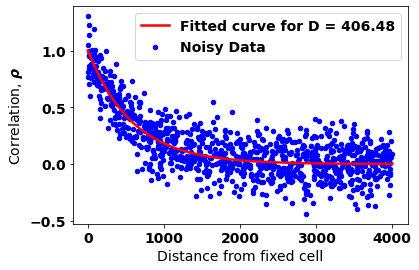

In [102]:
#np.#random.seed(8)
#a function that generates n random samples, with distance values of a given range
def generate_random_samples(n,lower_bound,upper_bound,err): 
    x = []
    y = []
    for i in range(n): 
        d= np.random.uniform(lower_bound,upper_bound) #generate random distance value from fixed cell as a sample from a uniform distribution, in the range L.B. to U.B.
        rho_noisy = generate_value(d,err)
        
        x.append(d)
        y.append(rho_noisy)
    return (x,y)

my_dict = {key: 0 for key in range(0, 4001)}
#Generate scatter plot of distance vs correlation, with random colors to help differentiate overlapping points. 
m = 1000 #number of samples
x,y = generate_random_samples(m,0,MaxDistance,e) #pass distance bounds and st. error
plt.figure(0)
plt.scatter(x,y, c='blue', s=20) 

plt.xlabel("Distance from fixed cell")
plt.ylabel(r'Correlation, $\rho$')
rp0 = np.random.uniform(100,1000) #sample initial random guess of D-hat for curve fitting
params, covs = optimize.curve_fit(cordist, xdata = x, ydata = y, p0=rp0) #fit curve with generated data and initial guess for parameter as 400km

print("D-hat estimate: ", params) #this prints the value of b (corr. distance) estimated from the curve fit on the generated data
print("covariance: ", covs)

#Plot the fitted curve by calculating y values based on rho without noise
axis_d = np.array(range(MaxDistance)) #prepare the axis for the fitted line
yfit = 2**(-axis_d/params[0]) #use the estimated D-hat for the fitted line
plt.plot(axis_d, yfit, c='red',linewidth='2.5')
l_strg = "Fitted curve for " + "D" + " = " + str(round(params[0],2))
plt.legend((l_strg,'Noisy Data'))



As shown above, the data follows the negative exponential shape, with some noise, as expected. The output "params:" gives the estimated value $\hat{D}$, correlation distance based on the curve fitted on the generated data.

<h2>Random sampling</h2>

Next, we repeat the random sampling procedure 500 times, by looping over the number of samples taken, *m*, and investigating the effect on the resulting correlation distance estimated by the fitted curve. Here, we plot the resulting $\hat{D}$ estimate from the curve fit against the number of samples used to fit the curve, $m$.

In [103]:
#set variables used to store parameter estimates
#np.#random.seed(8)
my_dict = {key: 0 for key in range(0, 4001)}
iterations = 1000 #the maximum number of samples to generate. Each iteration i will generate i samples.
sample_size = [] #this list is used as the axis in the plot, as we start from 2 and not 0.
Dhat_arr_rnd = [] #store D-hat estimate per sampling iteration
cov_arr_rnd = [] #store covariance estiamte per sampling iteration


UpperBound = MaxDistance#4000
xR , yR = [],[]
m = 4 #no. of samples per iteration
#generate random samples, with sample size "n" equal to each iteration number
for i in range(0,iterations):   
    sample_size.append(i)   #this list will be used as the x-axis in the plots, and it should start from sample size = 2
    pair =  generate_random_samples(m,LowerBound,MaxDistance,e)     #generate i samples, with each distance value being within the range given, and st. error = e
    xR.extend(pair[0])
    yR.extend(pair[1])

    params, covs = optimize.curve_fit(cordist, xdata = xR, ydata = yR, p0=rp0)    #fit curve with generated data and initial guess for parameter as 400km

    Dhat_arr_rnd.append(params[0]) #append the D-hat estimate to the D-hat array
    cov_arr_rnd.append(sqrt(covs[0][0])) #do the same for the covariance array

<h2>Adjusted Binary Search: Version 2</h2>

In [104]:
Dhat_arr2 = []
cov_arr2 = []
my_dict = {key: 0 for key in range(0, 4001)}
#np.#random.seed(8)

# LPS: I've now made the bounds a constant that you can change easily
LowerBound = 100
UpperBound = MaxDistance#4000

p_low = generate_value(LowerBound,e) #generate values for rho for distances 100km and 1000km using the neg. exp. model (again, with noise)
p_upper = generate_value(UpperBound,e)

x2 = [LowerBound,UpperBound]
y2 = [p_low,p_upper] #store distance and rho values in lists for easy plotting


params, covs = optimize.curve_fit(cordist, xdata = x, ydata = y, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates


Dhat_arr2.append(params[0]) #Dhat_arr[0] becomes our first estimate for correlation distance
cov_arr2.append(sqrt(covs[0][0])) #we also store covariance to plot later
#Now take the mean:

m1 = (LowerBound+Dhat_arr2[0]) * 0.5
m2 = (UpperBound+Dhat_arr2[0]) * 0.5

#Calculate correlation for each new distance value and fit curve on these two + previous two points:

m1_rho = generate_value(m1,e)
m2_rho = generate_value(m2,e)

x2.append(m1)
y2.append(m1_rho)
x2.append(m2)
y2.append(m2_rho)

params, covs = optimize.curve_fit(cordist, xdata = x2, ydata = y2, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates

Dhat_arr2.append(params[0]) #new estimate of correlation distance, D-hat
cov_arr2.append(sqrt(covs[0][0]))
print("x size before iteratiing:",len(x2))
i_arr = [0,1]  #used as x axis to plot iteration number. the loop will start from iteration no. 1(not 0) and the list will be updated each time.

for i in range(1,iterations):
    i_arr.append(i+1) #update every iteration

    mid_Dhat = 0.5 * (Dhat_arr2[i] + Dhat_arr2[i-1])
    rho_mid_Dhat = generate_value(mid_Dhat,e)
    x2.append(mid_Dhat)
    y2.append(rho_mid_Dhat)
    
    if Dhat_arr2[i] < Dhat_arr2[i-1]: #take two distances between Dhat[i] and 100. We used mean for one distance, but for two we will use 1st and 3rd quartile.
        q1 = (Dhat_arr2[i]+LowerBound)*0.25
        q1_rho = generate_value(q1,e)
        q3 = (Dhat_arr2[i]+LowerBound)*0.75
        q3_rho = generate_value(q3,e)
        

        #take one point between Dhat[i] and 1000. We can use mean for a single point.
        m1 = (Dhat_arr2[i]+UpperBound) * 0.5
        m1_rho = generate_value(m1,e)

    else: #vice versa; take quartiles between Dhat[i] and 1000, and median between Dhat[i] and 100.
        q1 = (Dhat_arr2[i]+UpperBound)*0.25
        q1_rho = generate_value(q1,e)
        q3 = (Dhat_arr2[i]+UpperBound)*0.75
        q3_rho = generate_value(q3,e)

        m1 = (Dhat_arr2[i]+LowerBound) * 0.5
        m1_rho = generate_value(m1,e)
    
    x2.append(q1)        #append all distance-correlation pairs to the correct x and y lists
    y2.append(q1_rho)
    x2.append(q3)
    y2.append(q3_rho)
    x2.append(m1)
    y2.append(m1_rho)

    if i > 990:
        print("x size at i=",i,len(x2))

    params, covs = optimize.curve_fit(cordist, xdata = x2, ydata = y2, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates
    Dhat_arr2.append(params[0]) #new estimate of corr. dist added to D-hat list
    cov_arr2.append(sqrt(covs[0][0]))




x size before iteratiing: 4
x size at i= 991 3968
x size at i= 992 3972
x size at i= 993 3976
x size at i= 994 3980
x size at i= 995 3984
x size at i= 996 3988
x size at i= 997 3992
x size at i= 998 3996
x size at i= 999 4000


<h2>Uncertainty Sampling</h2>

x size before iteratiing: 3
Dhat before loop: 351.4573369632882
std. before loop: 434.64279005129606

negative a! -> -300.5068481136559
negative a! -> -22.915468271668317


Text(0, 0.5, 'Correlation, $\\rho$')

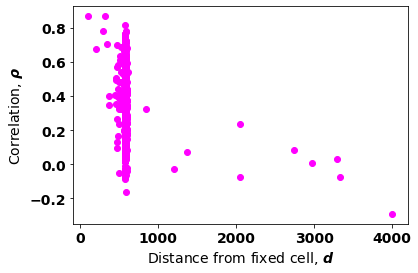

In [115]:
Dhat_arr_u = []
cov_arr_u = []
my_dict = {key: 0 for key in range(0, 4001)}
LowerBound = 100
UpperBound = MaxDistance#4000
p_low = generate_value(LowerBound,e) #generate values for rho for distances 100km and 1000km using the neg. exp. model (again, with noise)
p_upper = generate_value(UpperBound,e)

xu = [LowerBound,UpperBound]
yu = [p_low,p_upper] #store distance and rho values in lists for easy plotting

q1 = (LowerBound+UpperBound)/2
rhoq1 = generate_value(q1,e)

xu.append(q1)
yu.append(rhoq1)

params, covs = optimize.curve_fit(cordist, xdata = xu, ydata = yu, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates


Dhat_arr_u.append(params[0]) #new estimate of correlation distance, D-hat
cov_arr_u.append(sqrt(covs[0][0]))
print("x size before iteratiing:",len(xu))
i_arr_u = [0]  #used as x axis to plot iteration number. the loop will start from iteration no. 1(not 0) and the list will be updated each time.
print("Dhat before loop:",Dhat_arr_u[0])
print("std. before loop:",cov_arr_u[0])
#d = - (a*b*log(a/b)) / (log(2)*(b-a))
print()

for i in range(1,iterations):
    i_arr_u.append(i+1) #update every iteration

    for j in range(2,6):
        #print("Dhat:",Dhat_arr_u[i-1])
        #print("std:",cov_arr_u[i-1])
        sf = (j+1)/2
        #print("scalefactor",sf)
        b =  Dhat_arr_u[i-1] + sf * cov_arr_u[i-1] #the two interval bounds
        a =  Dhat_arr_u[i-1] - sf * cov_arr_u[i-1]

        #if a is negative, take 4 random points and move to next iteration of loop to prevent NaN error
        if a < 0: 
            print("negative a! ->",a)
            for k in range(0,4): 
                d = np.random.uniform(LowerBound,UpperBound)
                rhod = generate_value(d,e)
                xu.append(d)
                yu.append(rhod)
            break
            
        d = - (a*b*np.log(a/b)) / (np.log(2)*(b-a)) #get the max. distance between the curves; natural log by default for numpy
        rhod = generate_value(d,e)
        xu.append(d)
        yu.append(rhod)
        #print("interval:",a,b)
        #print("d:",d )
    
    params, covs = optimize.curve_fit(cordist, xdata = xu, ydata = yu, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates
    Dhat_arr_u.append(params[0]) #new estimate of correlation distance, D-hat
    cov_arr_u.append(sqrt(covs[0][0]))
    #print()


plt.figure(688)
plt.scatter(xu,yu,c='magenta',label='yu')
plt.xlabel("Distance from fixed cell, $d$")
plt.ylabel(r'Correlation, $\rho$')


<h2>Systematic Random</h2>

In [116]:
my_dict = {key: 0 for key in range(0, 4001)}
def samplechoice(lb,ub,numpoints):#calculate points and randomness range
    
    step = (ub - lb) / numpoints

    pts = [(lb+i*step) for i in range(0,numpoints)]
    randrange = (ub-lb)/(numpoints) 

    return(pts,randrange)

#np.#random.seed(8)
#random.seed(8)
Dhat_arr3 = []
cov_arr3 = []
x3 = []
y3 = []

i_arr3 = []  #used as x axis to plot iteration number. the loop will start from iteration no. 1(not 0) and the list will be updated each time.
pts, randrange = samplechoice(LowerBound,MaxDistance,m) #generate ten equidistant points with some noise range for randomness

#each iteration add some noise to the points generated above to create stochastic jitter
for i in range(0,iterations):
    i_arr3.append(i) #update every iteration

    for j in pts:
        #print("j:",j)
        d = j + np.random.uniform(-1*randrange,randrange) #add some noise to ensure different distances are sampled each time
        #print("d:",d)
        while(d > MaxDistance or d < LowerBound): #if distance is outside bounds, resample
            #print('d again')
            d = j + np.random.uniform(-1*randrange,randrange)
            #print('newd:',d)
        rho = generate_value(d,e)
        x3.append(d)
        y3.append(rho)


    params, covs = optimize.curve_fit(cordist, xdata = x3, ydata = y3, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates
    Dhat_arr3.append(params[0]) #new estimate of corr. dist added to D-hat list
    cov_arr3.append(sqrt(covs[0][0]))
    #print("i",i)




<h2>Greedy Sampling: Baseline</h2>
The following code is to demonstrate the midpoint generation. Note that the smallest interval is not always chosen to ensure the samples generated are not all on one extreme.

In [117]:
#np.#random.seed(8)
#random.seed(8)
my_dict = {key: 0 for key in range(0, 4001)}
def greedy_sampling(l): #return midpoints for 
    q = deque() #queue data structure to efficiently push and pop elements
    q.append([l]) #add bounds to the queue
    initial_dist = l[1] - l[0]
    exponent = 1
    while True:
        
        random.shuffle(q[0]) #ensures a random selection in case multiple pairs with the maximum distance exist
        #print("q before pop:",q)
        pair = q[0][-1] # Get a random pair of the largest interval as the next midpoint to calculate
        #print("pair:",pair[0],pair[1])
        q[0].pop()
        #print("q after pop:",q)
        midpoint = pair[0] + (initial_dist / pow(2, exponent)) #the interval is either the same as previous iter, or halved again (generation +=1)
        yield midpoint
        if len(q) == 1: #if there is only one interval list, add another one for the next interval
            q.append([])
        q[1].append((pair[0], midpoint)) #append left number of pair with midpoint as next pair to check
        q[1].append((midpoint, pair[1])) #append midpoint and right number of pair as next pair to check
        if len(q[0]) == 0: #if list with maximal distance is empty, use the next list as maximal distance and increase the power of 2
            q.popleft()
            exponent +=1 #this affects the power of two above


The following code uses the greedy sampling function to always pick the midpoint between pairs of points where the interval between them is maximal. The function is fitted using these new points each iteration.

In [118]:
#np.#random.seed(8)
#random.seed(8)
my_dict = {key: 0 for key in range(0, 4001)}
Dhat_greedy = []
Var_greedy = []
#begin with first two samples as the bounds of the range and fit function
bounds = [100,MaxDistance]
xG = [bounds[0]]
yG = [generate_value(bounds[0],e)]
xG.append(bounds[1])
yG.append(generate_value(bounds[1],e))
params, covs = optimize.curve_fit(cordist, xdata = xG, ydata = yG, p0=rp0) 
Dhat_greedy.append(params[0])
Var_greedy.append(sqrt(covs[0][0]))

i_arr2 = [0] #used as x-axis for plot
get_d = greedy_sampling(xG)
for i in range(1,iterations):
    i_arr2.append(i)


    for j in range(0,m):
        midp = next(get_d)
        midrho = generate_value(midp,e)
        xG.append(midp)
        yG.append(midrho)
    #print(greedy_d)

    params, covs = optimize.curve_fit(cordist, xdata = xG, ydata = yG, p0=rp0)
    Dhat_greedy.append(params[0])
    Var_greedy.append(sqrt(covs[0][0]))
    #print("Dhat:",Dhat_greedy)
    #print("Var:",Var_greedy)
    #print()






<h2>Comparing Results</h2>

Laurens' Sampling and Random Sampling results are compared below.

p0 value: 504.035543235762
error value: 0.15


<ipython-input-124-be590e638541>:45: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0,10**2])


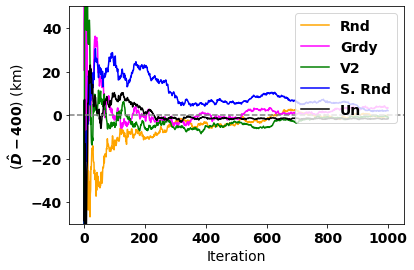

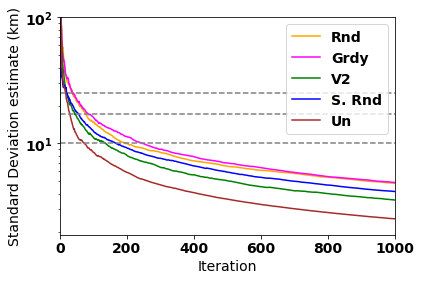

In [124]:
print("p0 value:",rp0)
print("error value:",e)

def absdiff(i):
    return (i-ValueTRUE)

#plot difference from true value
Dhat_arr_rnd_diff = [absdiff(i) for i in Dhat_arr_rnd] 
Dhat_arr_u_diff = [absdiff(i) for i in Dhat_arr_u] 
Dhat_arr2_diff = [absdiff(i) for i in Dhat_arr2]
Dhat_arr3_diff = [absdiff(i) for i in Dhat_arr3]
Dhat_greedy_diff = [absdiff(i) for i in Dhat_greedy]

#plot absolute difference (Dhat and actual true value of D)
plt.figure(8)
plt.plot(sample_size,Dhat_arr_rnd_diff, c='orange',label='Rnd' ) #random random
plt.plot(i_arr2,Dhat_greedy_diff,c='magenta',label='Grdy') #greedy
#plt.plot(i_arr,Dhat_arr_diff, c='red' ) #V1
plt.plot(i_arr,Dhat_arr2_diff, c='green', label = 'V2') #v2
plt.plot(i_arr3,Dhat_arr3_diff, c='blue',label='S. Rnd' ) #systematic random
plt.plot(i_arr_u,Dhat_arr_u_diff, c='black',label='Un' ) #systematic random
plt.axhline(y=0, color='gray', linestyle='--')
plt.ylim([-50,+50])
plt.ylabel('($\hat{D} - 400$) (km)')
plt.xlabel('Iteration')  
#plt.xlim(0,310)
plt.legend(loc="upper right")
#plt.legend(('V2','V3'),loc="upper right")


#plot standard deviation for the algorithms
plt.figure(6)
plt.plot(sample_size,cov_arr_rnd, c='orange' ,label='Rnd')
plt.plot(i_arr2,Var_greedy,c='magenta',label='Grdy')
#plt.plot(i_arr,cov_arr, c='red' ) 
plt.plot(i_arr,cov_arr2, c='green', label = 'V2' ) 
plt.plot(i_arr3,cov_arr3, c='blue',label='S. Rnd' )
plt.plot(i_arr_u,cov_arr_u, c='brown',label='Un' ) #systematic random
plt.axhline(y=(10), color='gray', linestyle='--')
plt.axhline(y=(25), color='gray', linestyle='--')
plt.axhline(y=(17), color='gray', linestyle='--')


plt.yscale('log')
plt.ylim([0,10**2])
plt.ylabel('Standard Deviation estimate (km)') # LPS: As there is only one variable, this is the variance of this variable. 
plt.xlabel('Iteration')  
plt.xlim(0,1000)
plt.legend(loc="upper right")
#plt.legend(('V2','V3'),loc="upper right")





NB! LPS: We see in the first figure that the Estimate from our code has a consisten underestimation of the Correlation Distance. We need to look into that!

MM: i've modified the plot to show absolute difference instead,

total no. of samples for Greedy 3998
total no. of samples for Random 4000
total no. of samples for V2 4000
total no. of samples for Systematic Random 4000


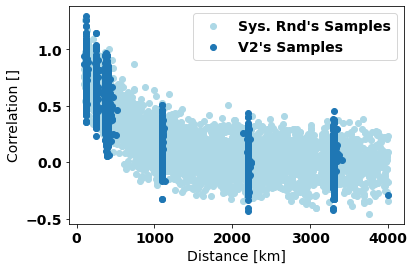

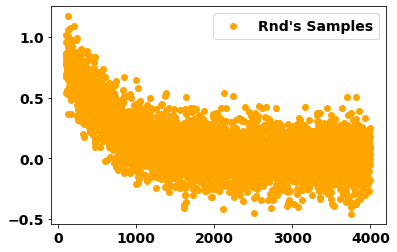

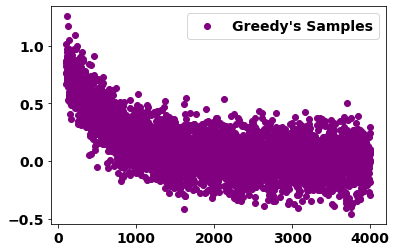

In [110]:
# LPS: added figure on the samples drawn by the end
plt.figure(7)
plt.scatter(x3,y3, label='Sys. Rnd\'s Samples', color='lightblue')
#plt.plot(np.arange(4000), cordist(np.arange(4000), *params), 'g--',label='fitted function')
plt.ylabel('Correlation []') 
plt.xlabel('Distance [km]')  
plt.legend(loc="upper right")

#I made one for V2 as well
plt.figure(7)
plt.scatter(x2,y2, label='V2\'s Samples')
#plt.plot(np.arange(4000), cordist(np.arange(4000), *params), 'g--',label='fitted function')
plt.ylabel('Correlation []') 
plt.xlabel('Distance [km]')  
plt.legend(loc="upper right")

plt.figure(10)
plt.scatter(xR,yR, label='Rnd\'s Samples',color='orange')
plt.legend(loc="upper right")

plt.figure(11)
plt.scatter(xG,yG, label='Greedy\'s Samples',color='purple')
plt.legend(loc="upper right")

print("total no. of samples for Greedy",len(xG))
print("total no. of samples for Random",len(xR))
print("total no. of samples for V2",len(x2))
print("total no. of samples for Systematic Random",len(x3))

action point: define a grid with 1 dec place (for noise), 2 grid versions (one with while loop and another with error dampening), implement same sampling methods on the grid, then run each algorithm 1000x and take mean of the samples, plot with error graphs to gauge spread.